In [20]:
!pip install xgboost

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, precision_recall_curve,
    average_precision_score, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.preprocessing import StandardScaler

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\sam\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import os
os.chdir(r"C:\Users\sam\BE\FYproject\saved_data\phase1")  #add your own directory
data_dir = "data/"
dfs = []
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/Test-1542969243754.csv
data/Test_Beneficiarydata-1542969243754.csv
data/Test_Inpatientdata-1542969243754.csv
data/Test_Outpatientdata-1542969243754.csv
data/Train-1542865627584.csv
data/Train_Beneficiarydata-1542865627584.csv
data/Train_Inpatientdata-1542865627584.csv
data/Train_Outpatientdata-1542865627584.csv


In [6]:
train_ben_df= pd.read_csv(r"data\Train_Beneficiarydata-1542865627584.csv")
train_ip_df = pd.read_csv(r"data\Train_Inpatientdata-1542865627584.csv")
train_op_df = pd.read_csv(r"data\Train_Outpatientdata-1542865627584.csv")
train_df    = pd.read_csv(r"data\Train-1542865627584.csv")

In [7]:
# Combine Claims
# -------------------------
claims = pd.concat([train_ip_df, train_op_df], ignore_index=True)

# Merge with beneficiary data
claims = claims.merge(train_ben_df, on="BeneID", how="left")


In [8]:
fraud_providers = train_df[train_df["PotentialFraud"]=="Yes"]["Provider"]
claims["PotentialFraud"] = claims["Provider"].isin(fraud_providers).astype(int)
claims["ClaimStartDt"] = pd.to_datetime(claims["ClaimStartDt"])
claims["ClaimEndDt"]   = pd.to_datetime(claims["ClaimEndDt"])
claims["ClaimDuration"] = (claims["ClaimEndDt"] - claims["ClaimStartDt"]).dt.days + 1


In [9]:
# Diagnosis & Procedure counts
diag_cols = [c for c in claims.columns if c.startswith("ClmDiagnosisCode")]
proc_cols = [c for c in claims.columns if c.startswith("ClmProcedureCode")]
claims["NumDiagnosis"] = claims[diag_cols].notna().sum(axis=1)
claims["NumProcedure"] = claims[proc_cols].notna().sum(axis=1)


In [10]:
# Ratios & flags
claims["ReimbToDurationRatio"] = claims["InscClaimAmtReimbursed"] / (claims["ClaimDuration"] + 1)
claims["RepeatedDiagnosisFlag"] = claims.groupby("BeneID")["ClmDiagnosisCode_1"].transform(
    lambda x: x.duplicated()
).astype(int)



In [11]:
claims.head()


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimDuration,NumDiagnosis,NumProcedure,ReimbToDurationRatio,RepeatedDiagnosisFlag
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,36000,3204,60,70,1,7,9,0,3250.000000,0
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,36000,3204,60,70,0,3,3,1,1250.000000,0
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,36000,3204,60,70,0,4,6,0,1000.000000,0
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,5000,1068,250,320,0,9,9,1,500.000000,0
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,21260,2136,120,100,0,18,9,1,526.315789,0


In [12]:
# Aggregate Features at Provider Level
# -------------------------
provider_features = claims.groupby("Provider").agg({
    "ClaimDuration": ["mean", "max", "min"],
    "NumDiagnosis": ["mean", "max"],
    "NumProcedure": ["mean", "max"],
    "RepeatedDiagnosisFlag": "mean",
    "ReimbToDurationRatio": ["mean", "max"],
    "InscClaimAmtReimbursed": ["sum", "mean"],
    "IPAnnualReimbursementAmt": "sum",
    "OPAnnualReimbursementAmt": "sum",
    "BeneID": "nunique"  # unique patients per provider
}).reset_index()


In [13]:
# Rename columns
provider_features.columns = ["Provider"] + [
    "_".join(col).strip() for col in provider_features.columns[1:]
]

# Make a copy of labels
labels = train_df[["Provider", "PotentialFraud"]].copy()
labels["PotentialFraud"] = labels["PotentialFraud"].map({"Yes": 1, "No": 0})  # safer

# Merge with encoded features
provider_features = provider_features.merge(labels, on="Provider", how="left")


In [14]:
X = provider_features.drop(columns=["Provider", "PotentialFraud"])
y = provider_features["PotentialFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [15]:
#smote anlysis
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)
lr = LogisticRegression(max_iter=5000, solver='lbfgs', random_state=42)
lr.fit(X_train_scaled, y_train_res)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [24]:
coefficients = lr.coef_[0]
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": coefficients,
    "Importance": np.abs(coefficients)
}).sort_values(by="Importance", ascending=False)

print("\nTop features:\n", feature_importance.head(10))


Top features:
                          Feature  Coefficient  Importance
13  OPAnnualReimbursementAmt_sum     2.746948    2.746948
14                BeneID_nunique    -1.690790    1.690790
10    InscClaimAmtReimbursed_sum     1.276719    1.276719
1              ClaimDuration_max     1.250432    1.250432
2              ClaimDuration_min    -1.239647    1.239647
9       ReimbToDurationRatio_max     1.180557    1.180557
11   InscClaimAmtReimbursed_mean     0.695435    0.695435
3              NumDiagnosis_mean     0.634960    0.634960
0             ClaimDuration_mean    -0.443277    0.443277
8      ReimbToDurationRatio_mean    -0.443099    0.443099


In [30]:
rf = RandomForestClassifier(
    n_estimators=300, max_depth=12, random_state=42,
    class_weight="balanced"
)
rf.fit(X_train_res, y_train_res)
#rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       random_state=42)

In [32]:
feature_names = X_train.columns  
print(feature_names)

Index(['ClaimDuration_mean', 'ClaimDuration_max', 'ClaimDuration_min',
       'NumDiagnosis_mean', 'NumDiagnosis_max', 'NumProcedure_mean',
       'NumProcedure_max', 'RepeatedDiagnosisFlag_mean',
       'ReimbToDurationRatio_mean', 'ReimbToDurationRatio_max',
       'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean',
       'IPAnnualReimbursementAmt_sum', 'OPAnnualReimbursementAmt_sum',
       'BeneID_nunique'],
      dtype='object')


In [34]:
# Suppose X_train was your training features DataFrame
feature_names = X_train.columns  

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importance_df)


                         Feature  Importance
10    InscClaimAmtReimbursed_sum    0.205360
1              ClaimDuration_max    0.168306
9       ReimbToDurationRatio_max    0.133036
12  IPAnnualReimbursementAmt_sum    0.095085
5              NumProcedure_mean    0.092658
13  OPAnnualReimbursementAmt_sum    0.055004
6               NumProcedure_max    0.052395
14                BeneID_nunique    0.035426
11   InscClaimAmtReimbursed_mean    0.032991
0             ClaimDuration_mean    0.029742
8      ReimbToDurationRatio_mean    0.028251
3              NumDiagnosis_mean    0.024885
7     RepeatedDiagnosisFlag_mean    0.021995
4               NumDiagnosis_max    0.020515
2              ClaimDuration_min    0.004352


In [36]:
xgb = XGBClassifier(
    n_estimators=500, max_depth=8, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42, eval_metric="logloss"
)
xgb.fit(X_train_res, y_train_res)
#xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [37]:


importance = xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                         Feature  Importance
10    InscClaimAmtReimbursed_sum   32.839806
1              ClaimDuration_max   15.953776
9       ReimbToDurationRatio_max   12.087199
6               NumProcedure_max   10.474980
5              NumProcedure_mean    5.652143
13  OPAnnualReimbursementAmt_sum    5.462802
12  IPAnnualReimbursementAmt_sum    4.748378
3              NumDiagnosis_mean    4.164083
14                BeneID_nunique    3.887969
8      ReimbToDurationRatio_mean    3.832987
2              ClaimDuration_min    3.778810
7     RepeatedDiagnosisFlag_mean    3.606097
0             ClaimDuration_mean    3.438535
11   InscClaimAmtReimbursed_mean    3.422138
4               NumDiagnosis_max    3.167392


In [25]:
def evaluate_model(model, X_test,y_test,model_name="Model"):
    
       
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    precision, recall, _ = precision_recall_curve(y_test,y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f'AP={ap:.4f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({model_name})")
    plt.legend()
    plt.show()
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_test,y_prob,name=model_name)
    plt.show()


Logistic Regression Results:
Accuracy: 0.8983364140480592
Confusion Matrix:
 [[880 101]
 [  9  92]]
              precision    recall  f1-score   support

           0     0.9899    0.8970    0.9412       981
           1     0.4767    0.9109    0.6259       101

    accuracy                         0.8983      1082
   macro avg     0.7333    0.9040    0.7835      1082
weighted avg     0.9420    0.8983    0.9117      1082

ROC-AUC: 0.9564598661701034


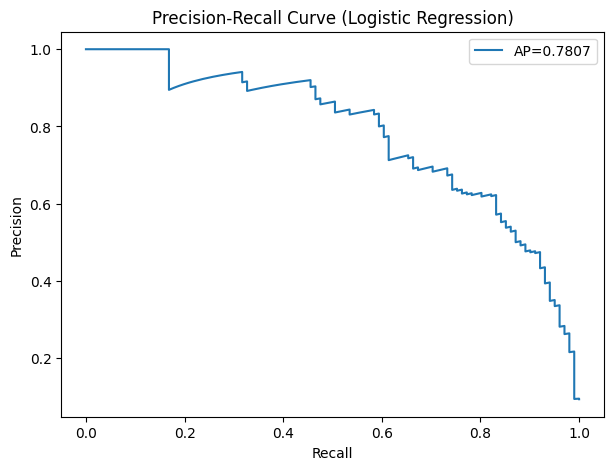

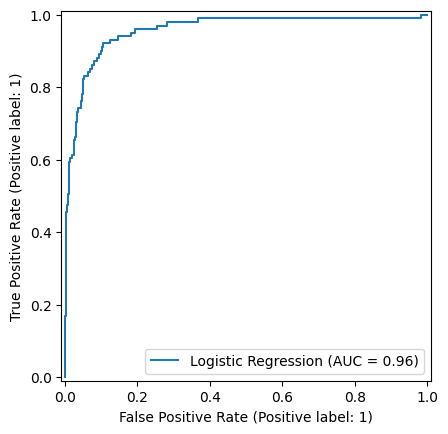

In [26]:
evaluate_model(lr,X_test_scaled,y_test,"Logistic Regression")


Random Forest Results:
Accuracy: 0.922365988909427
Confusion Matrix:
 [[920  61]
 [ 23  78]]
              precision    recall  f1-score   support

           0     0.9756    0.9378    0.9563       981
           1     0.5612    0.7723    0.6500       101

    accuracy                         0.9224      1082
   macro avg     0.7684    0.8550    0.8032      1082
weighted avg     0.9369    0.9224    0.9277      1082

ROC-AUC: 0.9662801142499571


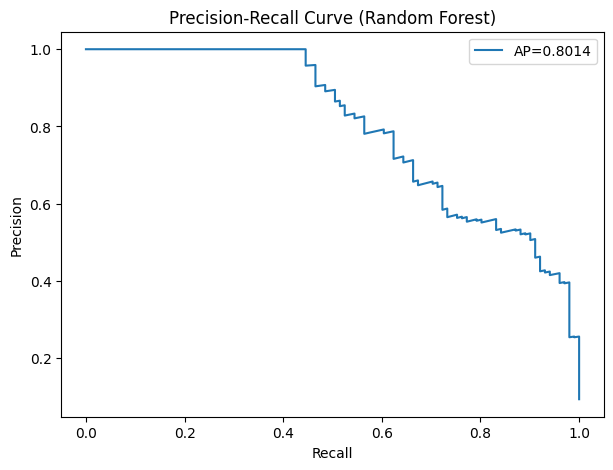

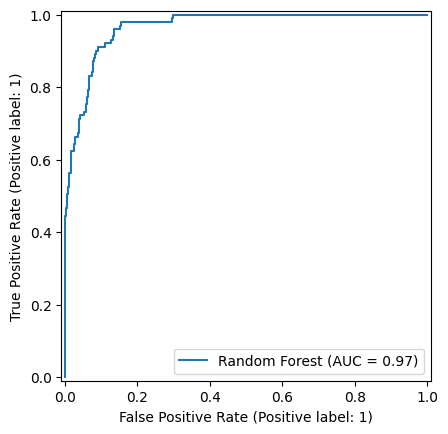

In [39]:
evaluate_model(rf, X_test, y_test,"Random Forest")



XGBoost Results:
Accuracy: 0.9121996303142329
Confusion Matrix:
 [[909  72]
 [ 23  78]]
              precision    recall  f1-score   support

           0     0.9753    0.9266    0.9503       981
           1     0.5200    0.7723    0.6215       101

    accuracy                         0.9122      1082
   macro avg     0.7477    0.8494    0.7859      1082
weighted avg     0.9328    0.9122    0.9196      1082

ROC-AUC: 0.9584784166490043


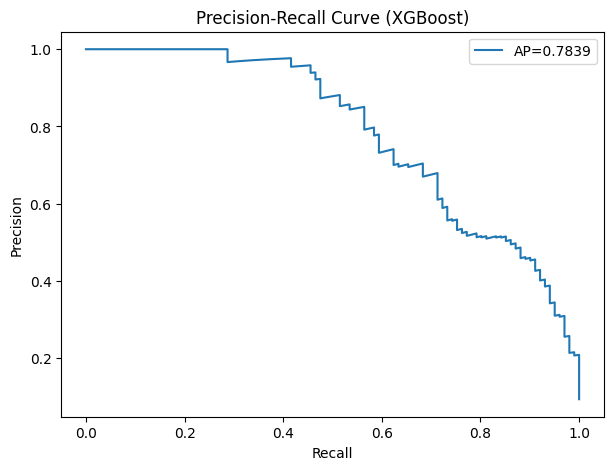

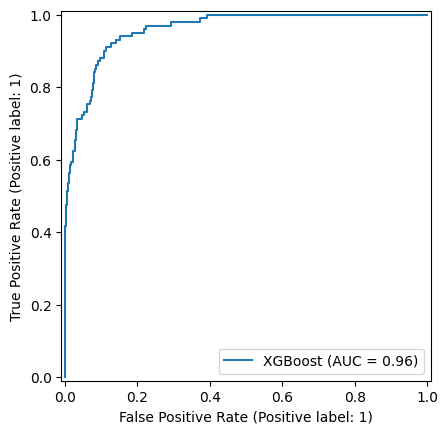

In [40]:
evaluate_model(xgb, X_test, y_test,"XGBoost")

In [27]:
joblib.dump(lr, "lr_model.pkl")

['lr_model.pkl']

In [42]:

joblib.dump(rf, "random_forest_model.pkl")


['random_forest_model.pkl']

In [73]:

joblib.dump(xgb, "xgboost_model.pkl")

['xgboost_model.pkl']

In [75]:
test_ben_df = pd.read_csv(r"data\Test_Beneficiarydata-1542969243754.csv")
test_ip_df  = pd.read_csv(r"data\Test_Inpatientdata-1542969243754.csv")
test_op_df  = pd.read_csv(r"data\Test_Outpatientdata-1542969243754.csv")
test_df     = pd.read_csv(r"data\Test-1542969243754.csv")   # has Provider IDs only (no fraud labels)


In [122]:

test_claims = pd.concat([test_ip_df, test_op_df], ignore_index=True)

# Merge with beneficiary data
test_claims = test_claims.merge(test_ben_df, on="BeneID", how="left")

# Convert date columns
test_claims["ClaimStartDt"] = pd.to_datetime(test_claims["ClaimStartDt"])
test_claims["ClaimEndDt"] = pd.to_datetime(test_claims["ClaimEndDt"])
test_claims["ClaimDuration"] = (test_claims["ClaimEndDt"] - test_claims["ClaimStartDt"]).dt.days + 1

# Diagnosis & Procedure counts
diag_cols = [c for c in test_claims.columns if c.startswith("ClmDiagnosisCode")]
proc_cols = [c for c in test_claims.columns if c.startswith("ClmProcedureCode")]
test_claims["NumDiagnosis"] = test_claims[diag_cols].notna().sum(axis=1)
test_claims["NumProcedure"] = test_claims[proc_cols].notna().sum(axis=1)

# Ratios & flags
test_claims["ReimbToDurationRatio"] = test_claims["InscClaimAmtReimbursed"] / (test_claims["ClaimDuration"] + 1)
test_claims["RepeatedDiagnosisFlag"] = test_claims.groupby("BeneID")["ClmDiagnosisCode_1"].transform(
    lambda x: x.duplicated()
).astype(int)

test_provider_features = test_claims.groupby("Provider").agg({
    "ClaimDuration": ["mean", "max", "min"],
    "NumDiagnosis": ["mean", "max"],
    "NumProcedure": ["mean", "max"],
    "RepeatedDiagnosisFlag": "mean",
    "ReimbToDurationRatio": ["mean", "max"],
    "InscClaimAmtReimbursed": ["sum", "mean"],
    "IPAnnualReimbursementAmt": "sum",
    "OPAnnualReimbursementAmt": "sum",
    "BeneID": "nunique"  # unique patients per provider
}).reset_index()

# Rename columns (same as training)
test_provider_features.columns = ["Provider"] + [
    "_".join(col).strip() for col in test_provider_features.columns[1:]
]

# Ensure all test providers are included (even if not in claims data)
# This is important in case some providers in test_df don't have claims
test_provider_features = test_df[["Provider"]].merge(
    test_provider_features, on="Provider", how="left"
)

# Handle any missing values that might occur from providers with no claims
test_provider_features = test_provider_features.fillna(0)

print(f"Training provider features shape: {provider_features.shape}")
print(f"Test provider features shape: {test_provider_features.shape}")
print(f"Number of providers to predict: {len(test_df)}")

# Verify column alignment with training data
train_feature_cols = [col for col in provider_features.columns if col not in ['Provider', 'PotentialFraud']]
test_feature_cols = [col for col in test_provider_features.columns if col != 'Provider']

print(f"\nTraining features: {len(train_feature_cols)}")
print(f"Test features: {len(test_feature_cols)}")
print(f"Features match: {set(train_feature_cols) == set(test_feature_cols)}")

if set(train_feature_cols) != set(test_feature_cols):
    print("Missing in test:", set(train_feature_cols) - set(test_feature_cols))
    print("Extra in test:", set(test_feature_cols) - set(train_feature_cols))

Training provider features shape: (5410, 17)
Test provider features shape: (1353, 16)
Number of providers to predict: 1353

Training features: 15
Test features: 15
Features match: True


In [158]:
test_provider_features.to_csv("test_provider_features.csv", index=False)

print(f"Shape: {test_provider_features.shape}")
print(f"Columns: {list(test_provider_features.columns)}")

Shape: (1353, 16)
Columns: ['Provider', 'ClaimDuration_mean', 'ClaimDuration_max', 'ClaimDuration_min', 'NumDiagnosis_mean', 'NumDiagnosis_max', 'NumProcedure_mean', 'NumProcedure_max', 'RepeatedDiagnosisFlag_mean', 'ReimbToDurationRatio_mean', 'ReimbToDurationRatio_max', 'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean', 'IPAnnualReimbursementAmt_sum', 'OPAnnualReimbursementAmt_sum', 'BeneID_nunique']


In [156]:

model_path = "xgboost_model.pkl"
with open(model_path, 'rb') as file:
    trained_model = pickle.load(file)
test_provider_features = pd.read_csv("test_provider_features.csv")
# Select first 13 rows for prediction
first_13_rows = test_provider_features.head(13).copy()

feature_names = [
    'ClaimDuration_mean', 'ClaimDuration_max', 'ClaimDuration_min',
    'NumDiagnosis_mean', 'NumDiagnosis_max', 'NumProcedure_mean',
    'NumProcedure_max', 'RepeatedDiagnosisFlag_mean',
    'ReimbToDurationRatio_mean', 'ReimbToDurationRatio_max',
    'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean',
    'IPAnnualReimbursementAmt_sum', 'OPAnnualReimbursementAmt_sum',
    'BeneID_nunique'
]

print(f"Expected features for model: {len(feature_names)}")
missing_features = [f for f in feature_names if f not in first_13_rows.columns]
if missing_features:
    print(f"WARNING: Missing features in test data: {missing_features}")

# Select only required features
X_test_sample = first_13_rows[feature_names]
print(f"\nFeature matrix shape for prediction: {X_test_sample.shape}")
print(f"Feature columns match training: {list(X_test_sample.columns) == feature_names}")

try:
    if hasattr(trained_model, 'predict_proba'):
        fraud_probabilities = trained_model.predict_proba(X_test_sample)[:, 1]
        fraud_predictions = trained_model.predict(X_test_sample)
    else:
        fraud_predictions = trained_model.predict(X_test_sample)
        fraud_probabilities = None

    results = pd.DataFrame({
        'Provider': first_13_rows['Provider'],
        'PotentialFraud': fraud_predictions
    })

    if fraud_probabilities is not None:
        results['Fraud_Probability'] = fraud_probabilities
        results['Fraud_Percentage'] = (fraud_probabilities * 100).round(2)

    results['Fraud_Label'] = results['PotentialFraud'].map({1: 'Yes', 0: 'No'})
    print(results.to_string(index=False))

    fraud_count = sum(fraud_predictions)
 
    print(f"Total providers analyzed: {len(fraud_predictions)}")
    print(f"Predicted as fraudulent: {fraud_count}")
    print(f"Predicted as legitimate: {len(fraud_predictions) - fraud_count}")

except Exception as e:
    print(f"\nTest features shape: {X_test_sample.shape}")
    print(f"Test features columns: {list(X_test_sample.columns)}")
    print(f"Any missing values: {X_test_sample.isnull().sum().sum()}")
    print(f"Error: {e}")


Expected features for model: 15

Feature matrix shape for prediction: (13, 15)
Feature columns match training: True
Provider  PotentialFraud  Fraud_Probability  Fraud_Percentage Fraud_Label
PRV51002               0           0.058445              5.84          No
PRV51006               0           0.000155              0.02          No
PRV51009               0           0.053321              5.33          No
PRV51010               0           0.066306              6.63          No
PRV51018               0           0.000815              0.08          No
PRV51019               0           0.009965              1.00          No
PRV51020               0           0.001008              0.10          No
PRV51022               0           0.002718              0.27          No
PRV51028               0           0.000183              0.02          No
PRV51033               0           0.000251              0.03          No
PRV51034               0           0.000939              0.09         

In [160]:
import os
print(os.getcwd())


C:\Users\sam\Downloads


In [34]:
import joblib
import pandas as pd

# Load model
lr_model = joblib.load("lr_model.pkl")

# Load test data
test_provider_features = pd.read_csv(r"C:\Users\sam\BE\FYproject\saved_data\phase1\testing.csv")
first_13_rows = test_provider_features.head(13).copy()

feature_names = [
    'ClaimDuration_mean', 'ClaimDuration_max', 'ClaimDuration_min',
    'NumDiagnosis_mean', 'NumDiagnosis_max', 'NumProcedure_mean',
    'NumProcedure_max', 'RepeatedDiagnosisFlag_mean',
    'ReimbToDurationRatio_mean', 'ReimbToDurationRatio_max',
    'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean',
    'IPAnnualReimbursementAmt_sum', 'OPAnnualReimbursementAmt_sum',
    'BeneID_nunique'
]

X_test_sample = first_13_rows[feature_names]

# ✅ No scaler needed here (unless you scaled before training)
fraud_probabilities = lr_model.predict_proba(X_test_sample)[:, 1]
fraud_predictions = lr_model.predict(X_test_sample)


C:\Users\sam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\sam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
